In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

import tessreduce as tr

from scipy.optimize import minimize
from scipy import signal
from astropy.convolution import Gaussian2DKernel

from scipy.optimize import minimize

def Delta_basis(Size = 13):
    kernal = np.zeros((Size,Size))
    x,y = np.where(kernal==0)
    middle = int(len(x)/2)
    basis = []
    for i in range(len(x)):
        b = kernal.copy()
        if (x[i] == x[middle]) & (y[i] == y[middle]):
            b[x[i],y[i]] = 1
        else:
            b[x[i],y[i]] = 1
            b[x[middle],y[middle]] = -1
        basis += [b]
    basis = np.array(basis)
    coeff = np.ones(len(basis))
    return basis, coeff

|   Sector | Covers   |   Time difference  |
|          |          |             (days) |
|----------+----------+--------------------|
|        6 | True     |                  0 |
|       33 | False    |                719 |
getting TPF from TESScut
made reference
!!!WARNING!!! mask is too dense, lowering mask_scale to 0.5, and raising maglim to 15. Background quality will be reduced.
made source mask
calculating background
background subtracted
calculating centroids


<IPython.core.display.Javascript object>


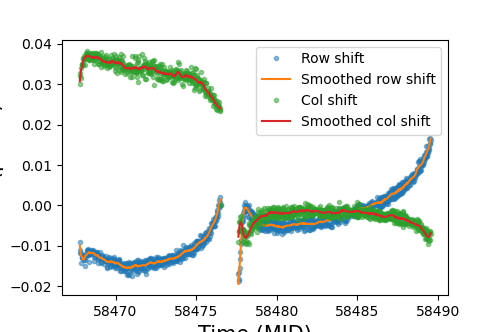

<IPython.core.display.Javascript object>


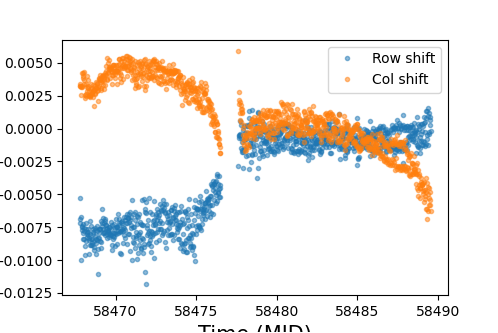

images shifted


<IPython.core.display.Javascript object>


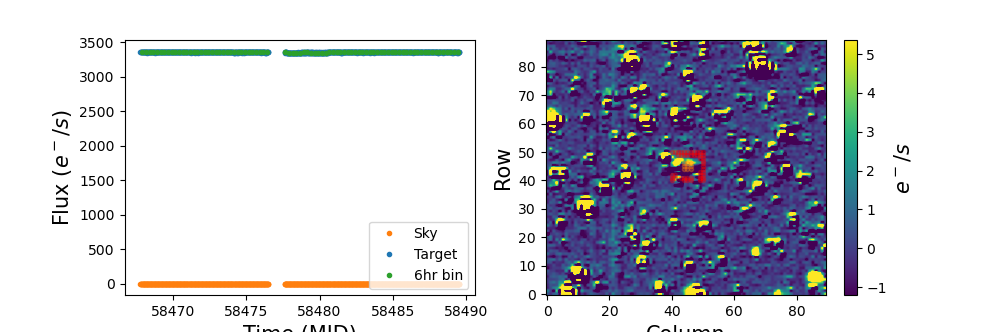

made reference
!!!WARNING!!! mask is too dense, lowering mask_scale to 0.5, and raising maglim to 15. Background quality will be reduced.
made source mask
calculating background
background subtracted
calculating centroids


<IPython.core.display.Javascript object>


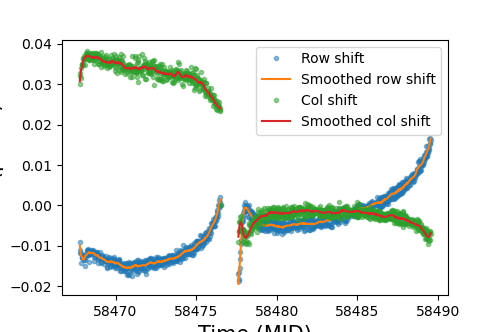

!!Re-running for difference image!!
shifting images
remade mask
background


<IPython.core.display.Javascript object>


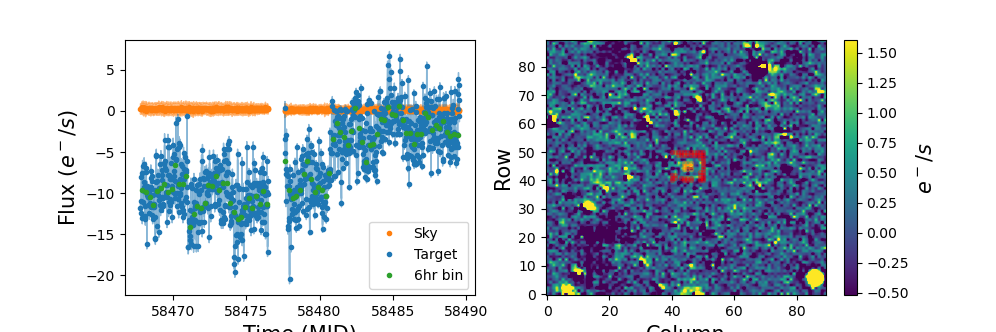

In [6]:
obs = tr.sn_lookup('sn2018lab')
#tess = tr.tessreduce(tpf='../../SN_individual/2020ghj/s23.fits',reduce=False,plot=True)
tess = tr.tessreduce(obs_list=obs,reduce=False,plot=True,align=True)
t2 = tr.deepcopy(tess)
tess.reduce(align=True,diff=False,calibrate=False)

t2.reduce(align=True,diff=True,double_shift=False,calibrate=False)

In [9]:
def Delta_kernal(Scene,Image,Size=7):
    Basis, coeff_0 = Delta_basis(Size)
    bds = []
    for i in range(len(coeff_0)):
        bds += [(0,1)]
    coeff_0 *= 0.01
    res = minimize(optimize_delta, coeff_0, args=(Basis,Scene,Image,Size),
                   bounds=bds)
    k = np.nansum(res.x[:,np.newaxis,np.newaxis]*Basis,axis=0)
    return k
        
def optimize_delta(Coeff, Basis, Scene, Image,size):
    Kernal = np.nansum(Coeff[:,np.newaxis,np.newaxis]*Basis,axis=0)

    template = fftconvolve(Scene, Kernal, mode='same')
    
    im = Image.copy()
    
    res = np.nansum(abs(im[size//2:-size//2]-template[size//2:-size//2]))
    #print(res)
    return res
    
    

In [124]:
test = tess.tpf.flux.value - tess.bkg

In [44]:
k = Delta_kernal(test[tess.ref_ind],test[410],Size=7)
template = signal.fftconvolve(test[tess.ref_ind], k, mode='same')

<IPython.core.display.Javascript object>


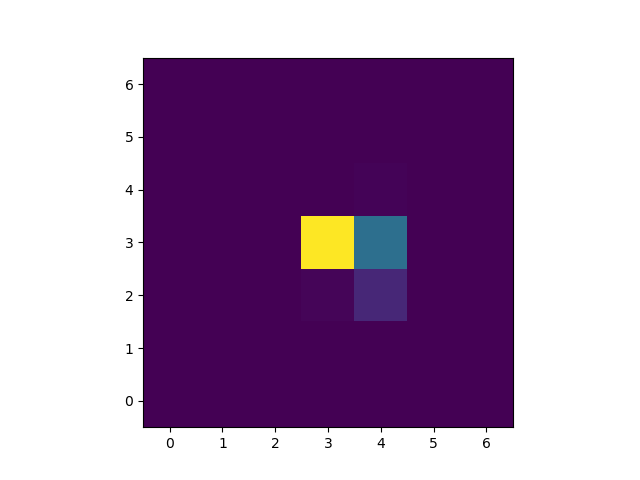

In [45]:
plt.figure()
plt.imshow(k,origin='lower',vmax=.007)

In [46]:
template = signal.fftconvolve(test[tess.ref_ind], k, mode='same')

<IPython.core.display.Javascript object>


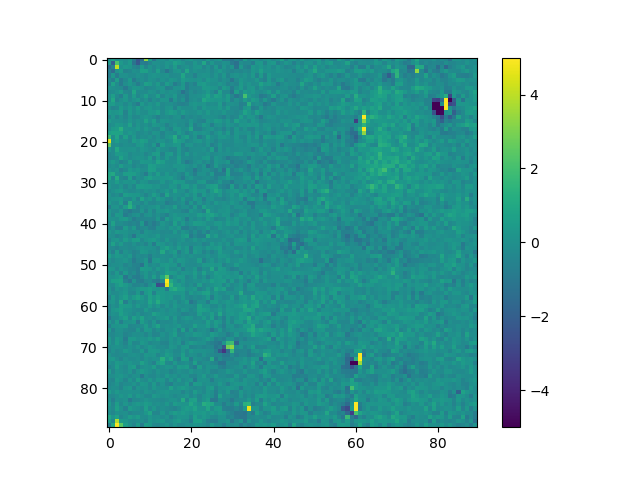

<IPython.core.display.Javascript object>


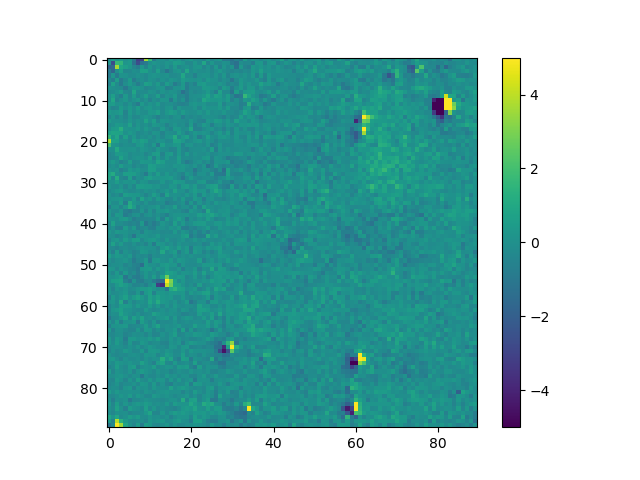

In [51]:
plt.figure()
plt.imshow(test[410]-template,vmin=-5,vmax=5)
plt.colorbar()

plt.figure()
plt.imshow(test[410]-test[tess.ref_ind],vmin=-5,vmax=5)
plt.colorbar()

In [24]:
def Make_temps(image, ref,size=7):
    k = Delta_kernal(ref,image,Size=size)
    template = fftconvolve(ref, k, mode='same')
    return template

In [64]:
ref = test[tess.ref_ind]
temps = np.zeros_like(test)
for i in range(test.shape[0]):
    k = Delta_kernal(ref,test[i],Size=7)
    template = fftconvolve(ref, k, mode='same')
    print(i)



0
1






  3%|▎         | 32/1235 [00:14<00:35, 33.85it/s]

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


KeyboardInterrupt: 

In [125]:
ref = test[tess.ref_ind]
import multiprocessing
from joblib import Parallel, delayed
from tqdm import tqdm
num_cores = multiprocessing.cpu_count()
tmps = Parallel(n_jobs=num_cores)(delayed(Make_temps)(ref,test[i]) for i in tqdm(range(test.shape[0])))    

100%|██████████| 1235/1235 [06:18<00:00,  3.26it/s] 


In [126]:
shift = np.array(tmps)

<IPython.core.display.Javascript object>


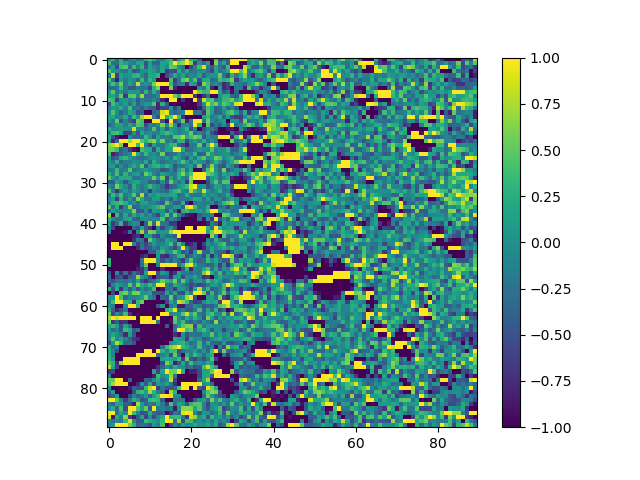

In [128]:
plt.figure()
plt.imshow(ref-np.nanmedian(shift[:800],axis=(0)),vmin=-1,vmax=1)
plt.colorbar()

In [129]:
dif = shift - ref

<IPython.core.display.Javascript object>


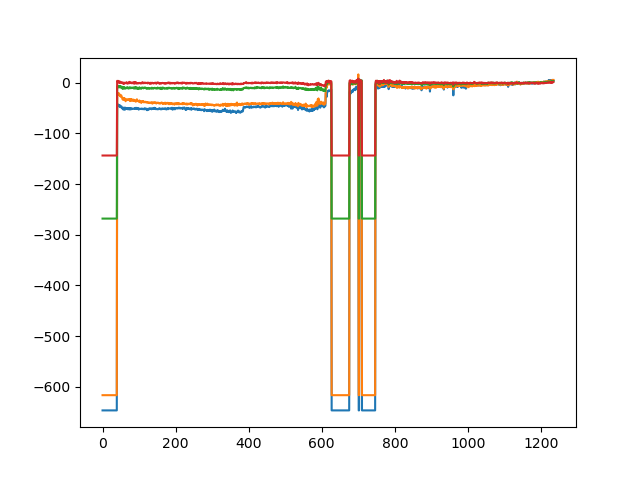

In [130]:
plt.figure()
plt.plot(dif[:,45,45])
plt.plot(dif[:,46,44])
plt.plot(dif[:,44,44])
plt.plot(dif[:,43,44])

In [131]:
lc = np.nansum(dif[:,44:47,44:47],axis=(1,2))
lc -= np.nanmedian(lc[:800])

<IPython.core.display.Javascript object>


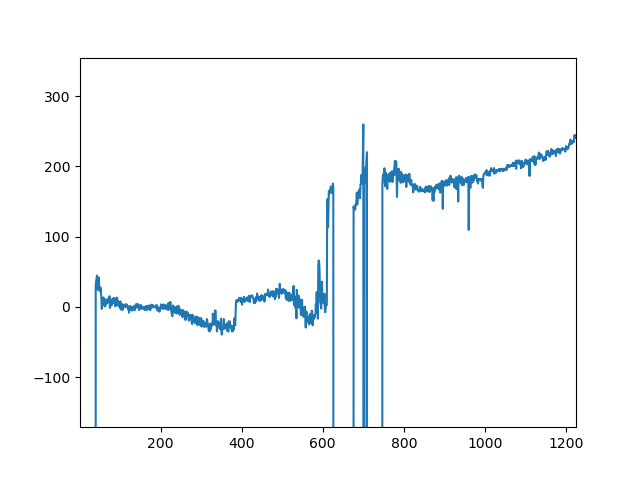

In [132]:
lc = np.nansum(dif[:,44:47,44:46],axis=(1,2))
lc -= np.nanmedian(lc[:800])

plt.figure()
plt.plot(lc)

In [302]:
sub = cor - templates
sub2 = f - templates

In [336]:
#lc1, sky1 = tr.diff_lc(sub,tpf=tpf,ra=ra,dec=dec,tar_ap=3,sky_in=3,sky_out=5)
lc1, sky1 = tr.diff_lc(cor,tpf=tpf,ra=ra,dec=dec)
lc2, sky2 = tr.diff_lc(cor,tpf=tpf,x=45,y=50)

/Users/rridden/miniconda3/lib/python3.7/site-packages/tessreduce/tessreduce.py:1423: LightkurveDeprecationWarning: The astropy_time function is deprecated and may be removed in a future version.
        Use time instead.
  tar = np.nansum(diff*ap_tar,axis=(1,2))


<IPython.core.display.Javascript object>


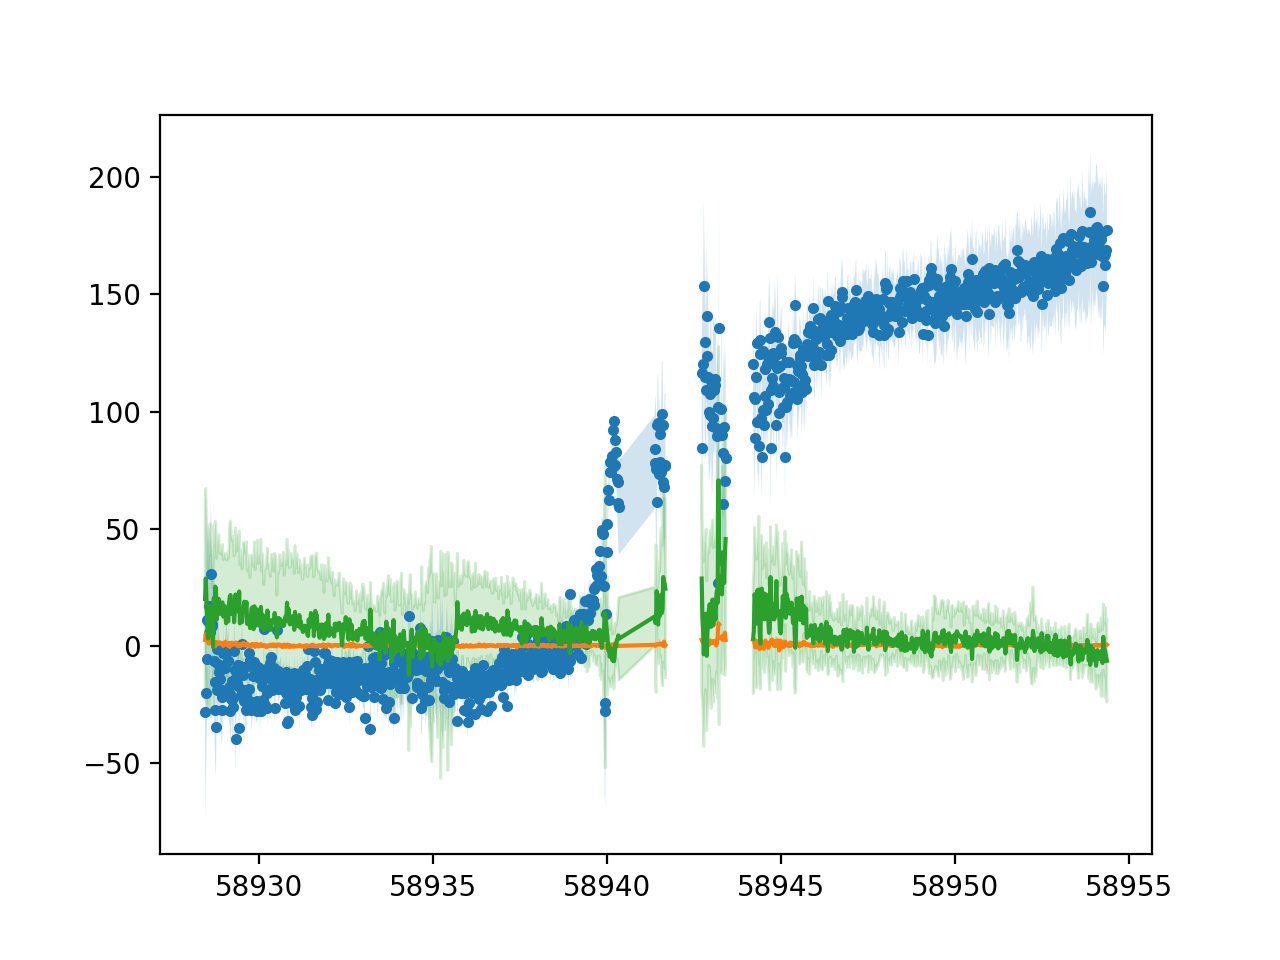

In [339]:
lc1[1] = lc1[1] - lc2[1]
plt.figure()
plt.fill_between(lc1[0],lc1[1]-lc1[2],lc1[1]+lc1[2],alpha=0.2)
plt.plot(lc1[0],lc1[1],'.')
plt.plot(sky1[0],sky1[1])

plt.fill_between(lc2[0],lc2[1]-lc2[2],lc2[1]+lc2[2],alpha=0.2,color='C2')
plt.plot(lc2[0],lc2[1],'C2')

<IPython.core.display.Javascript object>


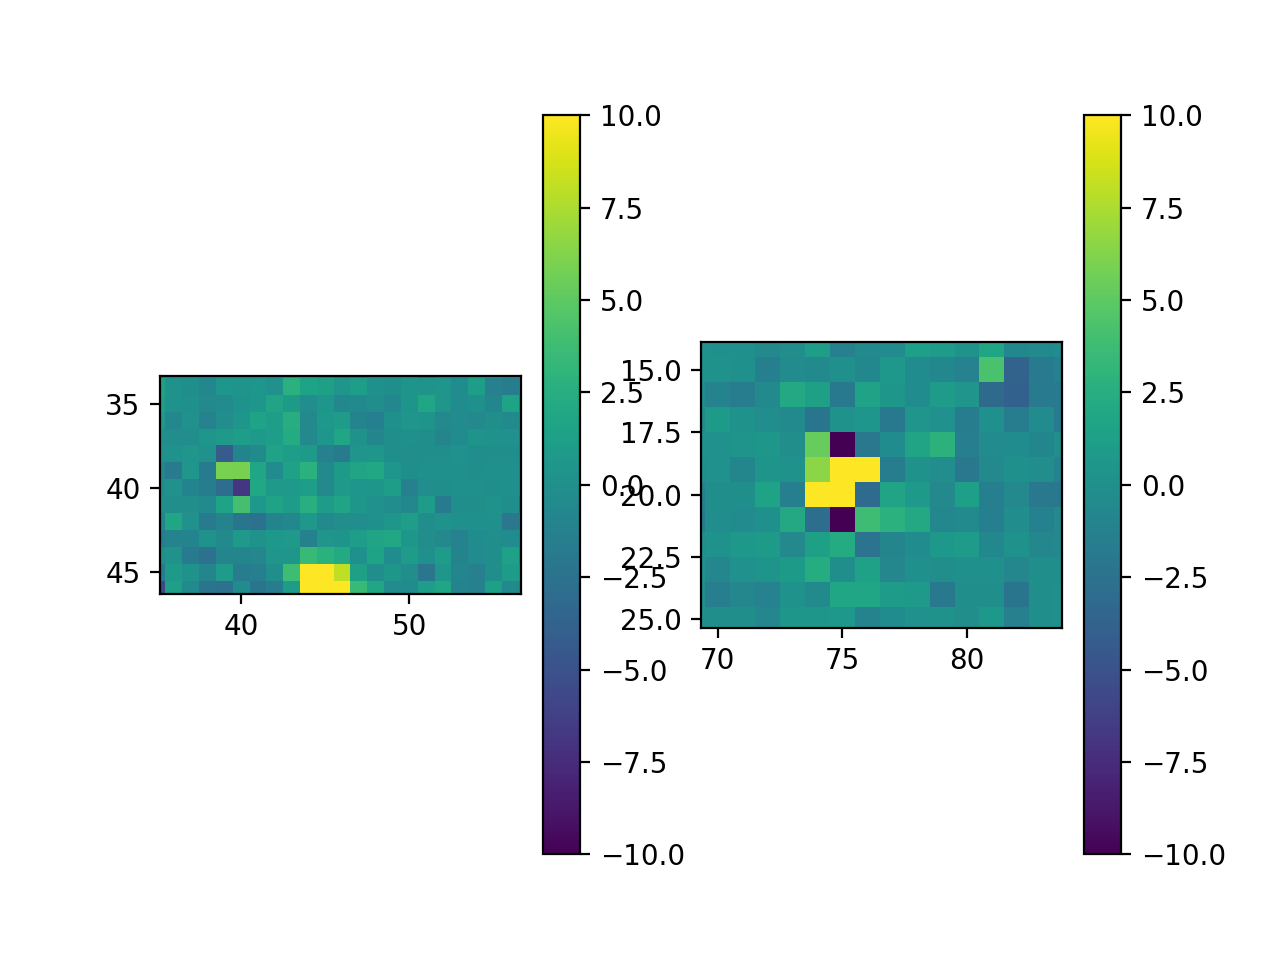

In [329]:
plt.figure()
plt.subplot(121)
plt.imshow(cor[1000]-ref,vmin=-10,vmax=10)
plt.colorbar()

plt.subplot(122)
plt.imshow(sub[1000],vmin=-10,vmax=10)
plt.colorbar()

In [266]:
test = np.zeros_like(cor[100])
test[45,45] = 1000
test = cor[100]
basis, coeff_0 = Delta_basis(7)
bds = []
for i in range(len(coeff_0)):
    bds += [(0,1)]
coeff_0 *= 0.01
res = minimize(optimize_delta, coeff_0, args=(basis,test,cor[1200]),bounds=bds)

In [267]:
res

      fun: 28593.7238408318
 hess_inv: <49x49 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 75540.83495052,  59841.74931655,  -1022.85048342,  15168.45622973,
       103427.63562221, 163714.92820326, 141696.15606079, 123573.095334  ,
       137198.57233809, 103442.49676564, 116821.70661516, 162602.86865872,
       166564.79092489,  89171.49243644,  88859.10428944,  87561.48818065,
         5001.80685779,   -398.15640769,  75488.99739049, 127685.56152878,
        40927.51005373,  48383.51524086,  19461.72633325,   1073.16373033,
         -779.27506545,   -521.37620515,  28704.90679925,  23290.83654331,
        59399.54135101,  88854.98500604,  54469.64642033,   2842.07417233,
        79390.41825011, 126001.68738572,  73005.60828298,  75953.47160532,
       163061.36130879, 172667.17040911, 140406.52968106, 178185.48330979,
       166449.42988933, 132111.61276558, 114586.14426374, 163762.64720748,
       126814.98119491,  64235.20098906, 154024.33018608, 215945.8505048 ,
   

In [12]:
from scipy.signal import fftconvolve

In [268]:
k = np.nansum(res.x[:,np.newaxis,np.newaxis]*basis,axis=0)
template = signal.fftconvolve(test, k, mode='same')

In [269]:
np.sum(Kernel)

1.0070876920910152

<IPython.core.display.Javascript object>


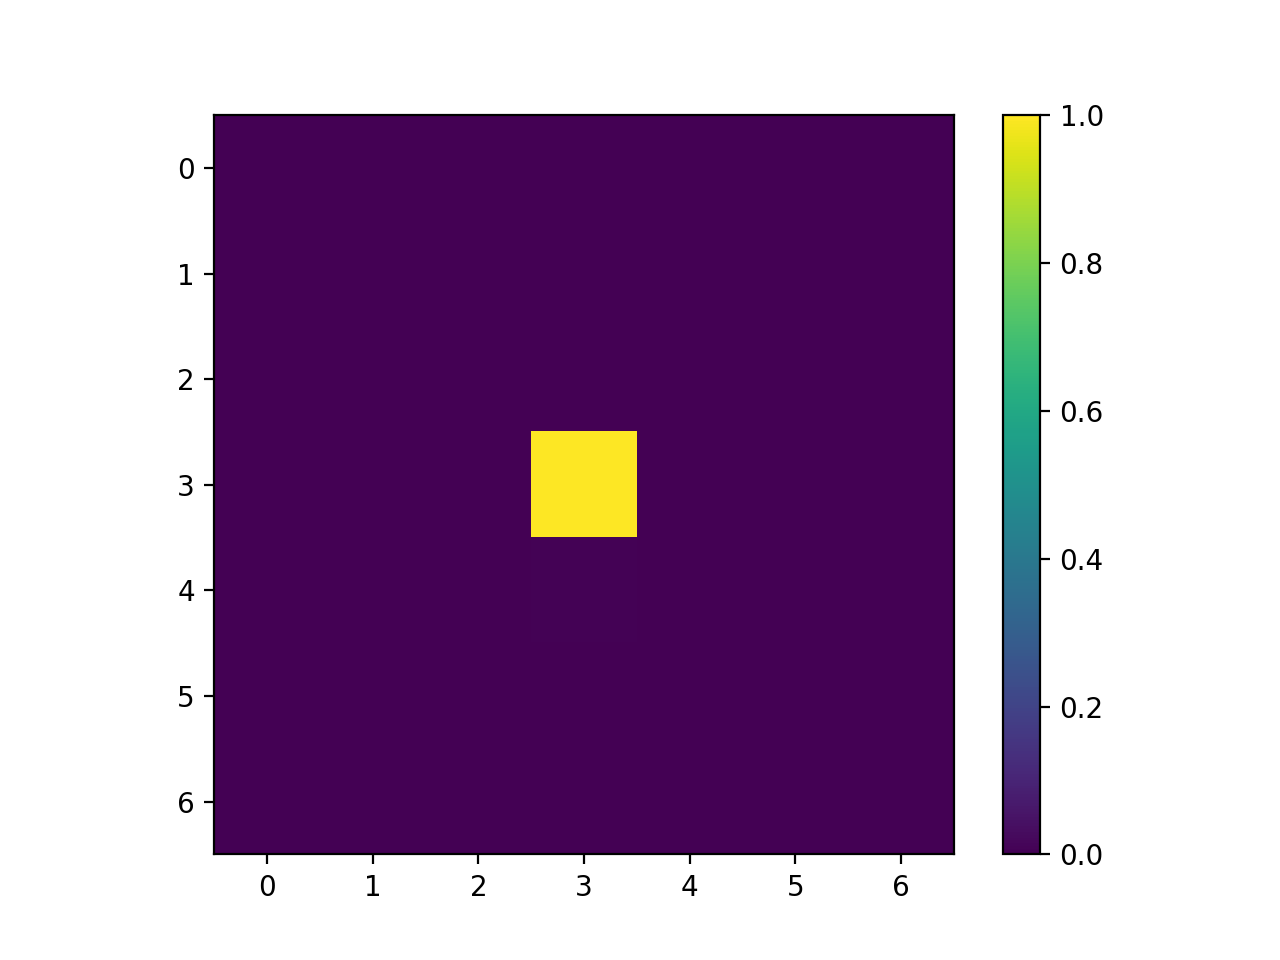

In [270]:
plt.figure()
plt.imshow(Kernel)
plt.colorbar()

In [271]:
np.nansum(template)


345993.441668765

In [272]:
np.nansum(test)

346331.7253642712

<IPython.core.display.Javascript object>


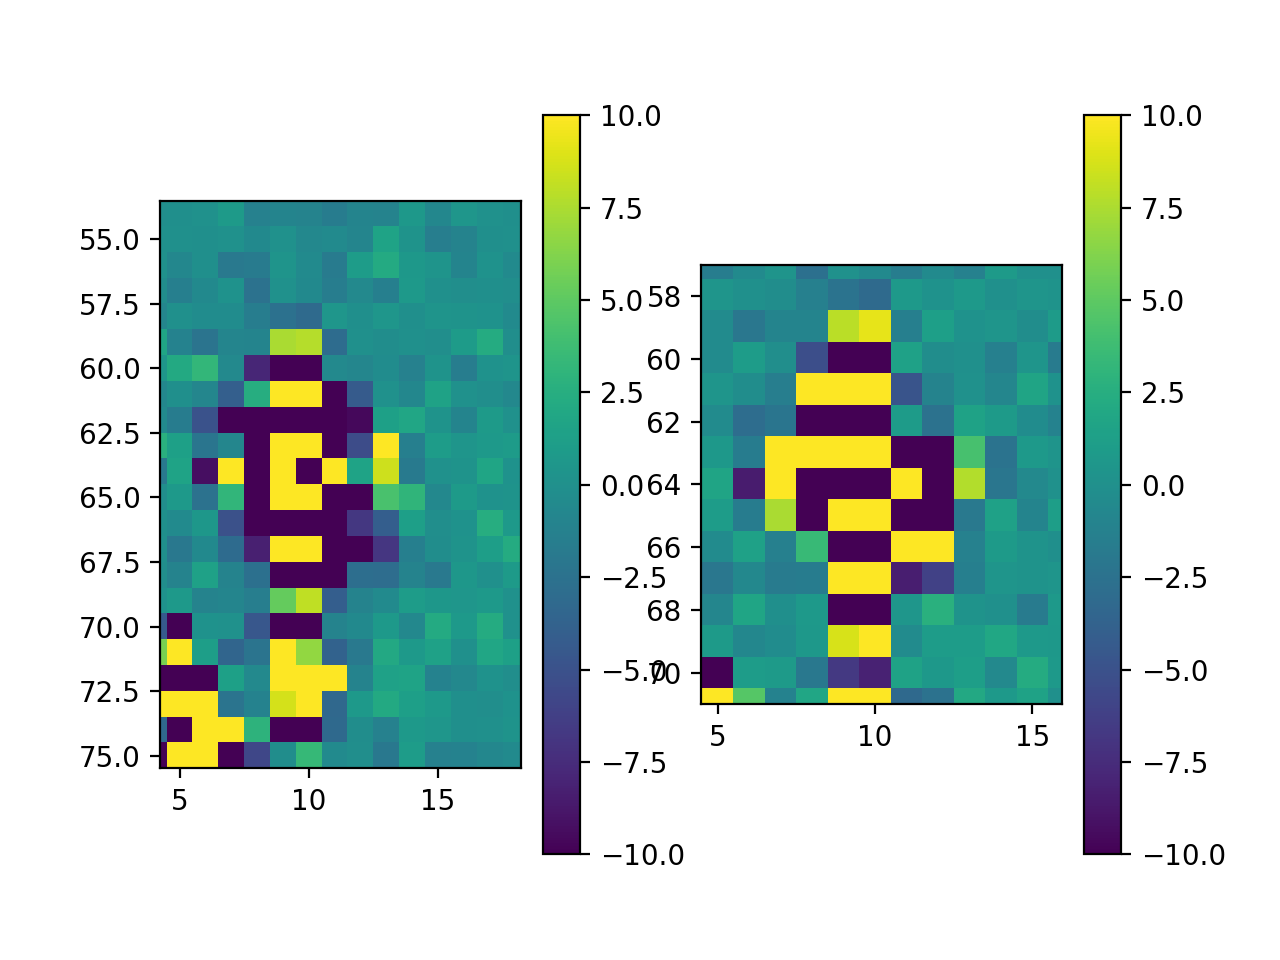

In [275]:
plt.figure()
plt.subplot(121)
plt.imshow(cor[1000]-template,vmin=-10,vmax=10)
plt.colorbar()

plt.subplot(122)
plt.imshow(cor[1000]-cor[100],vmin=-10,vmax=10)
plt.colorbar()

In [134]:
im = cor[1000].copy()
template = signal.fftconvolve(cor[100], Kernel, mode='same')
im[im< 10] = np.nan
res = np.nansum(abs(np.log10(im - np.log10(template))))

<IPython.core.display.Javascript object>


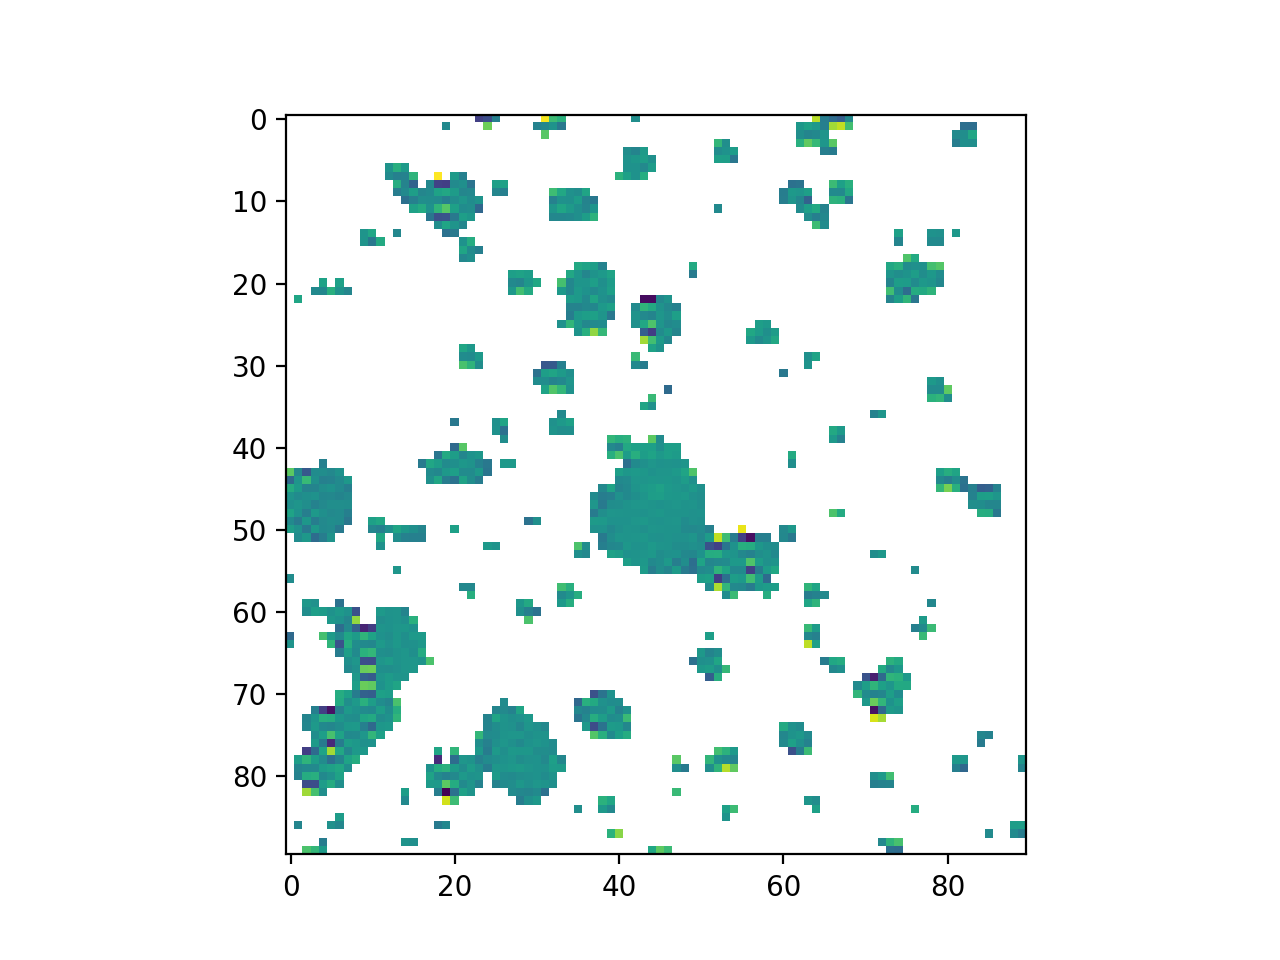

In [151]:
a = im/cor[100]-1
m = sigma_clip(a,sigma=5).mask
a[m] = np.nan

plt.figure()
plt.imshow(a)

In [144]:
mask

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True, False, False],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True, False, ...,  True,  True,  True]])

In [152]:
np.nansum(a)

-2.784360905651944

In [141]:
sigma_clip(im/cor[100]-1)

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, -0.04394740096840799, -0.10340481678647295],
        [--, --, --, ..., --, --, --],
        [--, --, 0.2212019122834521, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True, False, False],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True, False, ...,  True,  True,  True]],
  fill_value=1e+20)

In [140]:
from astropy.stats import sigma_clip

In [17]:
k = Delta_kernal(tess.flux[100],tess.ref,Size=15)
template = fftconvolve(tess.flux[100], k, mode='same')

In [ ]:
k = Delta_kernal(ref,image,Size=size)

<IPython.core.display.Javascript object>


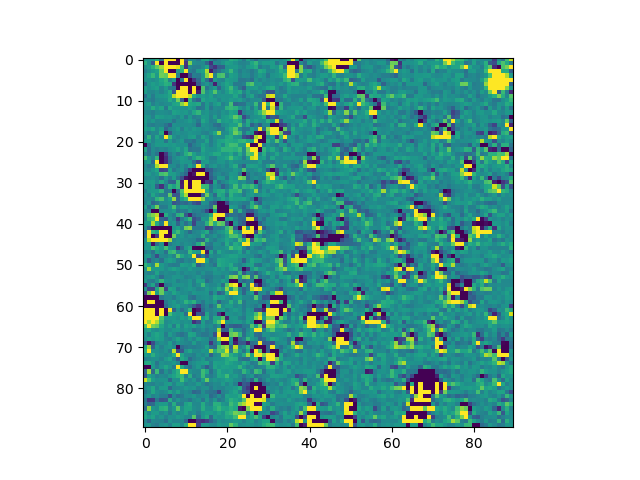

<IPython.core.display.Javascript object>


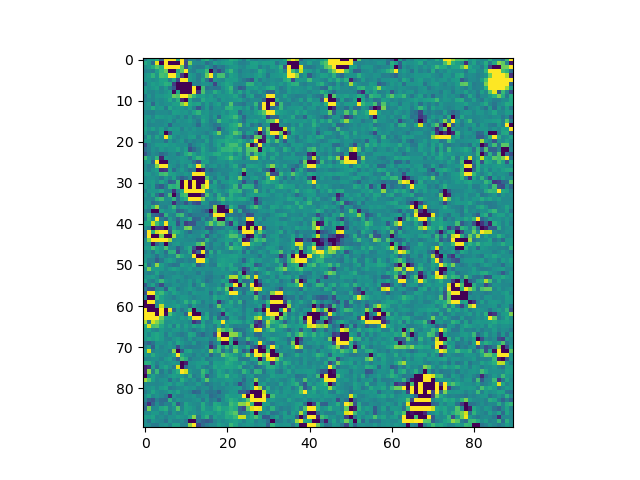

In [18]:
plt.figure()
plt.imshow(tess.flux[100]-tess.ref,vmin=-5,vmax=5)

plt.figure()
plt.imshow(template-tess.ref,vmin=-5,vmax=5)

<IPython.core.display.Javascript object>


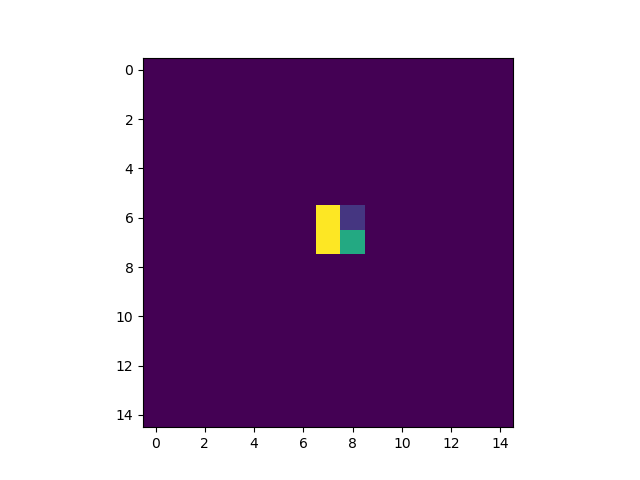

In [22]:
plt.figure()
plt.imshow(k,vmax=0.01)

In [25]:
ref = tess.ref
import multiprocessing
from joblib import Parallel, delayed
from tqdm import tqdm
num_cores = multiprocessing.cpu_count()
tmps = Parallel(n_jobs=num_cores)(delayed(Make_temps)(tess.flux[i],ref,13) for i in tqdm(range(tess.flux.shape[0])))    


 20%|█▉        | 195/987 [03:47<24:46,  1.88s/it]


 52%|█████▏    | 516/987 [10:58<06:47,  1.16it/s]


 86%|████████▌ | 847/987 [18:00<02:56,  1.26s/it]


100%|██████████| 987/987 [20:56<00:00,  1.27s/it]
